# Building a Binary Classification Model with XGBoost to Detect Orthopedic Anomalies


### Author

**Juan Sebastian Granados Jaimes**  
Student of Systems and Computer Engineering

📧 Email: juansebastiangranadosjaimes26@gmail.com

🔗 LinkedIn: [linkedin.com/in/juan-sebastian-granados-jaimes-304691272/](https://www.linkedin.com/in/juan-sebastian-granados-jaimes-304691272/)  

💻 GitHub: [github.com/SebastianGranadosJ](https://github.com/SebastianGranadosJ)


## About this project

This project focuses on training and evaluating a binary classification model to predict orthopedic anomalies using biometric data from patients.  
The model is built with **XGBoost**, and its performance is assessed through metrics such as sensitivity, specificity, accuracy, precision, and confusion matrix.  
To improve results, hyperparameter fine-tuning is performed using cross-validation and average error as the optimization criterion.

It was a nice learning experience. I hope this project can also help you learn something new or give you ideas for your own experiments in machine learning :)


## About the Dataset

The dataset used in this project comes from a biomedical study conducted by Dr. Henrique da Mota at the Group of Applied Research in Orthopaedics (GARO), Centre Médico-Chirurgical de Réadaptation des Massues in Lyon, France.  

It was designed to support two related classification tasks:

**Multiclass classification (3 classes):**
- *Normal (NO):* 100 patients
- *Disk Hernia (DH):* 60 patients
- *Spondylolisthesis (SL):* 150 patients

**Binary classification (2 classes):**
- *Normal (NO):* 100 patients
- *Abnormal (AB):* 210 patients (a combination of Disk Hernia and Spondylolisthesis)

For this project, we focus on the second task — a **binary classification problem** to distinguish between patients with normal conditions and those with orthopedic anomalies (abnormal).  

#### Dataset Features
Each patient is represented by six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine:

- Pelvic incidence  
- Pelvic tilt  
- Lumbar lordosis angle  
- Sacral slope  
- Pelvic radius  
- Degree of spondylolisthesis  

### Dataset Source
This dataset is publicly available at the **UCI Machine Learning Repository**:  
[Dua, D. & Graff, C. (2019). UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Vertebral+Column)


## Desarrollo del Labortorio

## Libraries Used

In this notebook, the following Python libraries are used:

- **Pandas** for data handling and preprocessing  
- **XGBoost** for model training  
- **Scikit-learn** for evaluation metrics and cross-validation  
- **Matplotlib & Seaborn** for visualization  


In [1]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import numpy as np

import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix


### Loading the Dataset



In [2]:
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])


In [3]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Abnormal'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Abnormal'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Abnormal'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Abnormal'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Abnormal'


In [4]:
df["class"].unique()

array([b'Abnormal', b'Normal'], dtype=object)

### 3. Encoding the Target Variable

The `class` column is our **target variable**.  
Since machine learning models work with numeric values, we map the categories as follows:

- **Normal → 0**  
- **Abnormal → 1**

In [5]:

class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

In [6]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1


In [7]:
cols = ['class'] + [col for col in df.columns if col != 'class']
df = df[cols]
df.head()



,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
0,1,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400
1,1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259
2,1,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317
3,1,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523
4,1,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501


### 4. Data Splitting

The dataset is divided into three subsets:  

1. **Train (80%)** → used to fit the model  
2. **Validation (10%)** → used for tuning and avoiding overfitting  
3. **Test (10%)** → used only at the end to evaluate final performance  

We use `train_test_split` with **stratified sampling** (`stratify`) to preserve class balance, and fix a `random_state` for reproducibility.


In [8]:
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

> **Note:** These subsets are saved as CSV files inside the `/database` folder, simulating a real training scenario where data would typically be stored in an external database rather than directly in the execution environment.


In [9]:
train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

train.to_csv('database/' + train_file, index = False, header=False)
test.to_csv('database/' + test_file, index = False, header=False)
validate.to_csv('database/' + validate_file, index = False, header=False)

### 5. Model Training  

In this step, the dataset is split into **features (`X`)** and the **target label (`y`)**, for both training and validation sets.  
- `X_train` and `X_val` contain only the biomechanical attributes (input columns).  
- `y_train` and `y_val` contain the target variable (`class`) that the model needs to predict.  

Since **XGBoost** works with its own optimized data structure called `DMatrix`, both sets are converted into this format:  
- `DMatrix` stores features and labels more efficiently.  
- It improves memory usage and training speed.  
- It allows the data to be passed directly into XGBoost’s internal algorithms.  

For this reason, we create `dtrain` (training data) and `dval` (validation data), each containing both the features and labels.


In [40]:
X_train = train.iloc[:, 1:] # Features
y_train = train.iloc[:, 0] # labels 

X_val = validate.iloc[:, 1:] # Features
y_val = validate.iloc[:, 0] # labels 


dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)




The model is configured and trained using **XGBoost**:  

1. **Parameters (`params`)**:  
   - `"objective": "binary:logistic"` → binary classification problem, predicting whether a subject has an orthopedic abnormality.  
   - `"eval_metric": "auc"` → the chosen evaluation metric is **AUC-ROC**, which measures how well the model separates the two classes (higher is better).  

2. **Evaluation list (`evals`)**:  
   Both `dtrain` and `dval` are included so that XGBoost reports the model’s performance on training and validation data, helping detect overfitting.  

3. **Training**:  
   The model is trained with `xgb.train`, using:  
   - the defined parameters,  
   - the training dataset (`dtrain`),  
   - `num_boost_round=42` (number of boosting iterations),  
   - and the evaluation sets (`evals`).  

At the end, the trained binary classification model is stored as `modelo_entrenado.model`.  


In [42]:

params = {
    "objective": "binary:logistic", 
    "eval_metric": "auc" 
} 

evals = [(dtrain, "train"), (dval, "validation")] 

model = xgb.train(params, dtrain, num_boost_round=42, evals=evals,  verbose_eval=False)

model.save_model("no_tunned.model")

The test set is prepared for the final evaluation:  

- `X_test` → input features.  
- `y_test` → true labels used to assess model performance.  
- `dtest` → features converted into an **XGBoost DMatrix**, required for prediction.  

Unlike training and validation, labels are not included in the DMatrix since this dataset is only used for generating predictions. 

In [12]:
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]
dtest = xgb.DMatrix(X_test)

In [13]:
class_predicted_probability = model.predict(dtest)

df_probs = pd.DataFrame(class_predicted_probability, columns=['class_predicted_probability'])

df_probs.head()


,class_predicted_probability
0,0.996712
1,0.601601
2,0.991119
3,0.996319
4,0.951055


### 6. Threshold Application  

Predicted probabilities are converted into binary classes using a **threshold of 0.65**:  
- `> 0.65` → `1` (*Abnormal*).  
- `≤ 0.65` → `0` (*Normal*).  

This threshold acts as the cutoff point. Instead of the default `0.5`, a higher value (`0.65`) is chosen to increase confidence before labeling a case as *Abnormal*. The final binary predictions are stored in the column `predicted_class`.  


In [14]:

def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0


df_probs['predicted_class'] = df_probs['class_predicted_probability'].apply(binary_convert)
df_probs.head()

,class_predicted_probability,predicted_class
0,0.996712,1
1,0.601601,0
2,0.991119,1
3,0.996319,1
4,0.951055,1


In [15]:
y_test = pd.Series(y_test).reset_index(drop=True)
df_probs["real_class"] = y_test
df_probs.head(15)

,class_predicted_probability,predicted_class,real_class
0,0.996712,1,1
1,0.601601,0,0
2,0.991119,1,1
3,0.996319,1,1
4,0.951055,1,1
5,0.996943,1,1
6,0.993199,1,1
7,0.983054,1,1
8,0.988389,1,0
9,0.626366,0,1


### 7. Model Evaluation  

Using the **confusion matrix**, several metrics are computed to assess model performance:  

- **Sensitivity (Recall)** → ability to detect positives.  
- **Specificity** → ability to detect negatives.  
- **Precision & NPV** → reliability of positive/negative predictions.  
- **Accuracy & AUC** → overall performance and discrimination between classes.  

These metrics together give a complete view of how well the model distinguishes between *Normal* and *Abnormal* cases.  


In [16]:
def plot_stats(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )


plot_stats(df_probs['real_class'], df_probs['predicted_class'])

Sensitivity or TPR: 80.95238095238095%
Specificity or TNR: 80.0%
Precision: 89.47368421052632%
Negative Predictive Value: 66.66666666666666%
False Positive Rate: 20.0%
False Negative Rate: 19.047619047619047%
False Discovery Rate: 10.526315789473683%
Accuracy: 80.64516129032258%
Validation AUC 0.8047619047619049


### Confusion Matrix  

A **confusion matrix** compares model predictions with the real labels, showing how many cases were correctly or incorrectly classified in each category.  



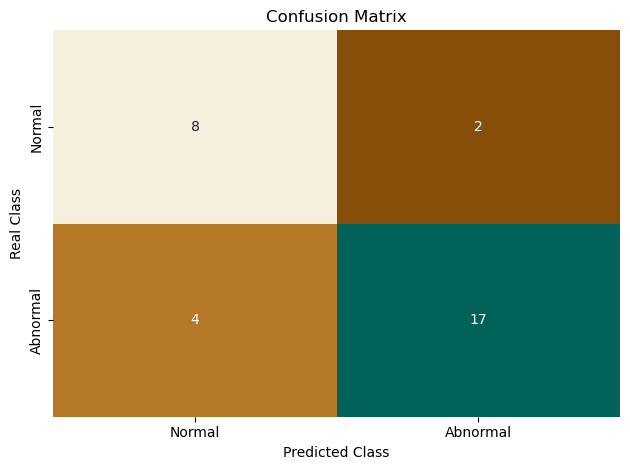

In [17]:

def plot_confusion_matrix(test_labels, target_predicted, class_yes="Es", class_no="No es"):
    # Matriz de confusión
    matrix = confusion_matrix(test_labels, target_predicted)
    
    # Convertir a DataFrame con etiquetas personalizadas
    df_confusion = pd.DataFrame(
        matrix, 
        index=[ class_no, class_yes],       # Etiquetas para el eje Y (clases reales)
        columns=[ class_no, class_yes]      # Etiquetas para el eje X (clases predichas)
    )
    
    # Colormap
    colormap = sns.color_palette("BrBG", 10)
    
    # Graficar con seaborn
    sns.heatmap(df_confusion, annot=True, fmt='d', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.ylabel("Real Class")
    plt.xlabel("Predicted Class")
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
plot_confusion_matrix(
    df_probs['real_class'], 
    df_probs['predicted_class'], 
    class_yes="Abnormal", 
    class_no="Normal"
)



### ROC Curve  

The **ROC curve** shows the trade-off between True Positive Rate (Sensitivity) and False Positive Rate at different thresholds.  

- A good model’s curve approaches the **top-left corner** (high sensitivity, low false positives).  
- The **diagonal line** represents random guessing.  
- The **AUC value** summarizes performance: the closer to 1, the better the model distinguishes between classes.  


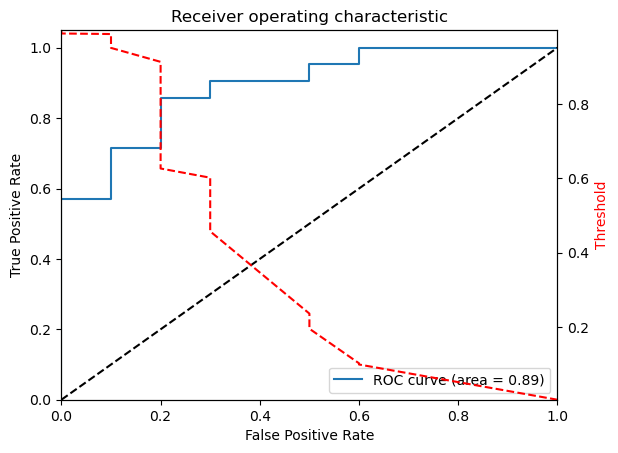

In [18]:


def plot_roc(test_labels, target_predicted_no_binary):
    fpr, tpr, thresholds = roc_curve(test_labels,target_predicted_no_binary)

    finite_indices = np.isfinite(thresholds) 
    fpr_finite = fpr[finite_indices]
    tpr_finite = tpr[finite_indices]
    thresholds_finite = thresholds[finite_indices]

    plt.figure()
    plt.plot(fpr_finite, tpr_finite, label='ROC curve (area = %0.2f)' % auc(fpr_finite, tpr_finite))
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")


    if thresholds_finite.size > 0:
        ax2 = plt.gca().twinx()
        ax2.plot(fpr_finite, thresholds_finite, markeredgecolor='r', linestyle='dashed', color='r')
        ax2.set_ylabel('Threshold', color='r')
        ax2.set_ylim([thresholds_finite[-1], thresholds_finite[0]])
        ax2.set_xlim([fpr_finite[0], fpr_finite[-1]])

plot_roc(df_probs['real_class'], df_probs["class_predicted_probability"] )

    

### 8. Hyperparameter Tuning

**Hyperparameters** are external settings of a machine learning model that are not learned during training and must be set beforehand.  

Here, we use **Optuna** to optimize hyperparameters for an **XGBoost** model. The `objective` function is executed multiple times by Optuna with different hyperparameter values to find the best combination.  

Ranges for hyperparameters (e.g., `alpha` from 0 to 100) were chosen to keep training time reasonable.  

#### Tuned Hyperparameters
- **alpha**: L1 regularization term to reduce overfitting.  
- **min_child_weight**: Minimum weight for tree leaves; higher values simplify trees.  
- **subsample**: Fraction of data used per tree to add randomness and prevent overfitting.  
- **eta** (*learning rate*): Controls update magnitude per iteration; lower values improve robustness but slow training.  
- **n_estimators**: Number of trees; more trees increase complexity but may overfit.  

#### `objective` Function
- Receives an Optuna `trial` proposing hyperparameter values.  
- Builds an `XGBClassifier` with these values.  
- Evaluates using **cross-validation** (`cv=3`), averaging scores over 3 folds.  
- Returns `1 - score` (average error) because Optuna **minimizes** the objective.  

#### Cross-Validation
**Cross-validation** assesses a model's generalization by splitting the dataset into multiple folds.  
Each iteration trains on some folds and evaluates on the rest, averaging performance for a more reliable metric.  



In [19]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial): 
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'alpha': trial.suggest_float('alpha', 0, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'eta': trial.suggest_float('eta', 0.1, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 1, 50)
    }
    
    model = XGBClassifier(**params) 
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()  

    return 1 - score  

 

### Running the Optimization

We initialize and run **Optuna** to find the best hyperparameters:

- `study = optuna.create_study(direction="minimize")`: creates an optimization study to **minimize** the error.  
- `study.optimize(objective, n_trials=3000)`: runs **3000 trials**, testing different hyperparameter combinations.  

After completion, `study` contains the best hyperparameter values found.


In [20]:

study = optuna.create_study(direction="minimize") ## inicializa la optimizacion diciendole que minimize
study.optimize(objective, n_trials=3000) # Lanza la optimizacion con el numero de intento y el la funcion objetive que va usar en cada uno



[I 2025-09-23 19:07:33,682] A new study created in memory with name: no-name-ebc64119-4f46-405d-bb55-beb73e79bcf8
[I 2025-09-23 19:07:33,724] Trial 0 finished with value: 0.3225585267900871 and parameters: {'alpha': 59.19240106184653, 'min_child_weight': 1.6674803511156977, 'subsample': 0.6374761151474494, 'eta': 0.1780945202009117, 'n_estimators': 11}. Best is trial 0 with value: 0.3225585267900871.
[I 2025-09-23 19:07:33,771] Trial 1 finished with value: 0.3225585267900871 and parameters: {'alpha': 17.59707324044435, 'min_child_weight': 3.396070978346966, 'subsample': 0.7859442486476743, 'eta': 0.2773929371059225, 'n_estimators': 42}. Best is trial 0 with value: 0.3225585267900871.
[I 2025-09-23 19:07:33,803] Trial 2 finished with value: 0.3225585267900871 and parameters: {'alpha': 27.495106881423425, 'min_child_weight': 2.2219896025835078, 'subsample': 0.8154192903886688, 'eta': 0.25688277698617556, 'n_estimators': 11}. Best is trial 0 with value: 0.3225585267900871.
[I 2025-09-23 1

These lines display the **best hyperparameters** found by Optuna and the **minimum error** achieved by the model using them.


In [21]:
print("Mejores hiperparámetros:", study.best_params, )
print(" Mejor valor", study.best_value)


Mejores hiperparámetros: {'alpha': 6.53684764869967, 'min_child_weight': 2.462228636921284, 'subsample': 0.7088079630226983, 'eta': 0.253498795898189, 'n_estimators': 40}
 Mejor valor 0.1411499657165246


### 9. Training with Best Hyperparameters

Using the best hyperparameters from Optuna, we create an **XGBoost** model, train it on all training data (`X_train`, `y_train`), and make predictions on the test set (`X_test`).


In [44]:
# Crear el modelo con los mejores hiperparámetros encontrados
model = XGBClassifier(**study.best_params)

# Entrenar en TODOS los datos de entrenamiento
model.fit(X_train, y_train)

# Hacer predicciones
y_pred_best_prob = model.predict_proba(X_test)[:, 1]

model.save_model("tunned_model.model")

### 10.Evaluación del modelo con los mejores hyperparametros

Al igual que anteriore pasos se organiza en un DataFrame la probabilidad predicha por modelo y la clase real

In [24]:
df_best_probs = pd.DataFrame(y_pred_best_prob, columns=['class_predicted_probability'])
df_best_probs["real_class"] = y_test
df_best_probs.head()

,class_predicted_probability,real_class
0,0.942950,1
1,0.515595,0
2,0.905142,1
3,0.919652,1
4,0.702617,1


### 10. Threshold Selection

The model's threshold is determined using the **ROC curve**, typically selecting the point that balances false positives (FP) and false negatives (FN), closest to the top-left corner of the curve.

However, the threshold decision should also consider the **medical context**. In this experiment, the goal is to detect orthopedic anomalies so patients receive proper treatment. False negatives are particularly serious: a patient with an anomaly could be misdiagnosed as healthy and miss needed care.

With this in mind, the threshold prioritizes a **high true positive rate**, even if it increases false positives. Lowering the threshold diagnoses more patients as anomalous, reducing false negatives. While this increases false positives, it is preferable for a healthy person to receive unnecessary treatment than for a sick patient to go untreated.

The ROC analysis suggests an optimal threshold around **0.6**, though this may vary per experiment and should be adjusted accordingly.


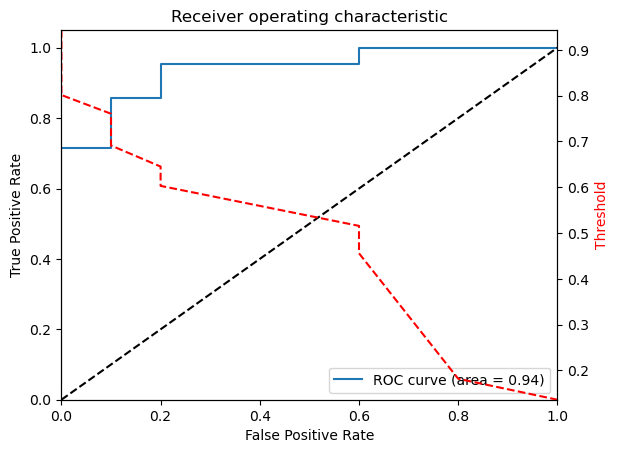

In [25]:
plot_roc(df_best_probs['real_class'], df_best_probs["class_predicted_probability"] )

In [32]:

def binary_convert(x):
    threshold = 0.6
    if x > threshold:
        return 1
    else:
        return 0
    
df_best_probs['predicted_class'] = df_best_probs['class_predicted_probability'].apply(binary_convert)


### Evaluation Metrics

The evaluation metrics show that the model achieves a **high true positive rate** and thus a **low false negative rate**, confirming that the chosen threshold meets the goal.  

Compared to the initial model, it indeed has a higher true positive rate. As expected, there is a **moderate rate of false positives**.


In [35]:
plot_stats(df_best_probs['real_class'], df_best_probs['predicted_class'])

Sensitivity or TPR: 95.23809523809523%
Specificity or TNR: 80.0%
Precision: 90.9090909090909%
Negative Predictive Value: 88.88888888888889%
False Positive Rate: 20.0%
False Negative Rate: 4.761904761904762%
False Discovery Rate: 9.090909090909092%
Accuracy: 90.32258064516128%
Validation AUC 0.8761904761904762




Only **one patient** with orthopedic anomalies was misclassified, indicating that the model effectively serves its purpose.


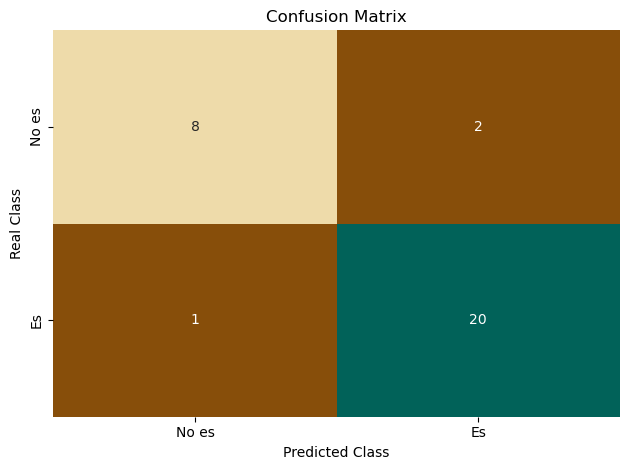

In [36]:
plot_confusion_matrix(df_best_probs['real_class'], df_best_probs['predicted_class'])
